# Ultrasound Classification Using Artificial Neural Networks
## Elena Denner

### Introduction
Ultrasounds are widely used tools to diagnose medical conditions, such as breast cancer. High-frequency sound waves are converted to images for viewing by a radiologist. However, radiologists may miss earlier forms of cancer and misdiagnose a tumor. The goal of this project is to build a deep neural network to classify potentially cancerous breast ultrasounds as benign, malignant, or normal. The DNN will learn the features of each class using the training set and predict classes for the test set using these learned features. A tumor will appear as an abnormal clustering of cells together. If a tumor exists, the net must classify it as either malignant or benign. Malignant tumors have a “finger-like” spreading appearance, abnormal shape, and large/dark nuclei. Benign tumors have a clear boundary, normal shape, and a normal nucleus. Benign tumors are noncancerous and do not tend to spread throughout the body. Malignant tumors are cancerous and can spread rapidly throughout the body if not removed. Malignant tumors are incredibly  dangerous while benign tumors are usually not dangerous, but sometimes can be if they press on vital organs (Conway Medical Center).


#### Import Modules and Functions

In [3]:
import os
import cv2
from tqdm import tqdm
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
import matplotlib.pyplot as plt
from tensorflow.random import set_seed
from tensorflow.keras import Sequential, optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout
from keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.applications
from keras.models import Model
from tensorflow.keras.layers import Input

Training deep neural networks is computationally expensive and a time consuming process. PlaidML is a framework we will use that enables deep learning using a computer’s GPU storage (as opposed to CPU). PlaidML allows users to train deep networks on their laptops without state of the art machines. The result is a significantly faster and more efficient training process. We will build our models using Keras, and access Keras through PlaidML. Keras is the application programming interface of Tensorflow 2, and provides powerful and flexible machine learning solutions.

In [5]:
import plaidml
import plaidml.keras
plaidml.keras.install_backend()
os.environ['KERAS_BACKEND'] = 'plaidml.keras.backend'

In [5]:
plt.rcParams.update({'font.size': 16})

### Read in ultrasound images and split into training and testing sets 
The data set for this project was composed by Aly Fahmy, a Professor of Computer Science from Cairo University (Al-Dhabyani W et. al). It consists of 780 total images of ultrasounds from potential breast cancer patients between the ages of 25 and 75. 437 of the images of cells have benign tumors, 210 have malignant tumors, and 133 are normal cells. The ultrasounds are stored as 500 X 500 grayscale images. After reading in the data, the images are randomly assigned to the training set (75%) and the testing set (25%). 

In [7]:
drty = '/Users/elena/Desktop/BreastCancer'
os.chdir(drty)

Categories = ["benign", "malignant", "normal"]

tumordata = []
img_size = 500

for category in Categories:
        
    path = os.path.join(drty,category)
    class_num = Categories.index(category)
        
    for img in tqdm(os.listdir(path)):
        if ('mask' not in img):
            img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
            img_array = cv2.resize(img_array, (img_size, img_size), cv2.IMREAD_GRAYSCALE)
            tumordata.append([img_array, class_num])
            
X = []
Y = []

for features, label in tumordata:
    X.append(features)
    Y.append(label)


# randomly split data into train and test sets
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size = 0.25, random_state = 42)

Xtrain = np.array(Xtrain, dtype=float)
Xtest = np.array(Xtest, dtype=float)
Ytrain = np.array(Ytrain)
Ytest = np.array(Ytest)

# save the training and testing sets
torch.save(Xtrain, 'Tumor_Xtrain.pt')
torch.save(Xtest, 'Tumor_Xtest.pt')
torch.save(Ytrain, 'Tumor_Ytrain.pt')
torch.save(Ytest, 'Tumor_Ytest.pt')


100%|██████████| 266/266 [00:01<00:00, 192.20it/s]



### Visualize each type of ultrasound
The plots below show an ultrasound of each class; benign, malignant, and normal. The classes of each ultrasound are coded as follows: 0 for benign, 1 for malignant, and 2 for normal. 

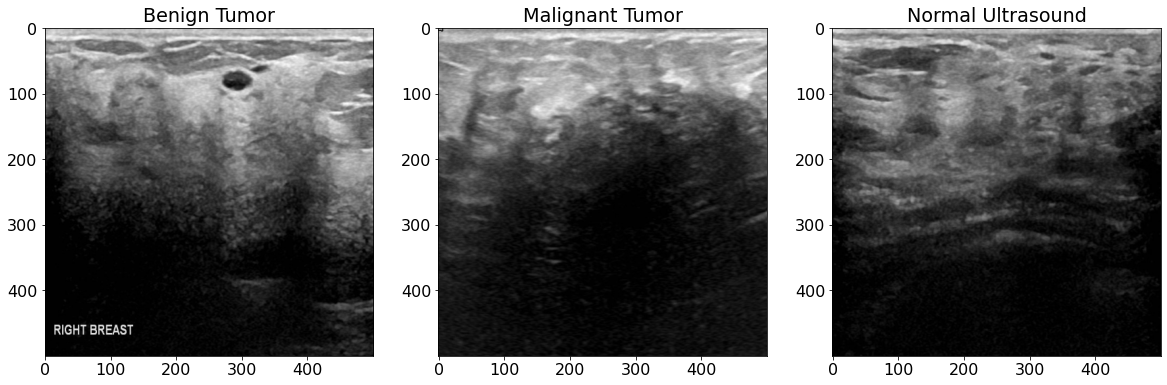

In [75]:
B = list(np.where(Ytrain == 0))
M = list(np.where(Ytrain == 1))
N = list(np.where(Ytrain == 2))

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,8))
ax1.imshow(Xtrain[B[0][0]], cmap = "gray")
ax2.imshow(Xtrain[M[0][0]], cmap = "gray")
ax3.imshow(Xtrain[N[0][0]], cmap = "gray")
ax1.title.set_text("Benign Tumor")
ax2.title.set_text("Malignant Tumor")
ax3.title.set_text("Normal Ultrasound")
plt.show()

### Pre-process the data 
The data must be pre-processed before we can train a neural network on it. For Keras, the image arrays must be coded as floats in [0,1] instead of integers. Additionally, the images need an extra channel dimension to have shape (500, 500, 1). The class of each image must be coded as a vector instead of a number, which means benign (class 0) is recoded as [1,0,0] and malignant (class 1) is recoded as [0,1,0] and normal (class 2) is recoded as [0,0,1]. 

In [9]:
x_train = torch.load('Tumor_Xtrain.pt')
x_test = torch.load('Tumor_Xtest.pt')
y_train = torch.load('Tumor_Ytrain.pt')
y_test = torch.load('Tumor_Ytest.pt')

print('x_train shape before pre-processing =', np.shape(x_train))
print('y_train shape before pre-processing =', np.shape(y_train))
print('x_test shape before pre-processing =', np.shape(x_test))
print('y_test  shape before pre-processing =', np.shape(y_test))
print()

# Convert images to floats in [0,1] instead of ints in [0,255]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Add extra channel dimension so images have shape (500, 500, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Convert labels to one-hot vectors (for categorical loss)
i = 1
print('Label before conversion:',y_train[i])
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
print('Label after conversion:',y_train[i])
print()

print('x_train shape after pre-processing =', np.shape(x_train))
print('y_train shape after pre-processing =', np.shape(y_train))
print('x_test shape after pre-processing =', np.shape(x_test))
print('y_test  shape after pre-processing =', np.shape(y_test))

# save xtrain, ytrain, xtest, ytest
np.save('xtrain_pre-processed', x_train)
np.save('ytrain_pre-processed', y_train)
np.save('xtest_pre-processed', x_test)
np.save('ytest_pre-processed', y_test)

x_train shape before pre-processing = (585, 500, 500)
y_train shape before pre-processing = (585,)
x_test shape before pre-processing = (195, 500, 500)
y_test  shape before pre-processing = (195,)

Label before conversion: 0
Label after conversion: [1. 0. 0.]

x_train shape after pre-processing = (585, 500, 500, 1)
y_train shape after pre-processing = (585, 3)
x_test shape after pre-processing = (195, 500, 500, 1)
y_test  shape after pre-processing = (195, 3)


### Model Building
Now we are ready to begin building a deep neural network. The following models experiment with convolutional layers, max pooling layers, linear layers, and regularization techniques. 20 epochs of size 128 are used for each model's training, and Adam is used as the optimizer. The number of trainable parameters, the cross entropy loss, and the test set accuracy is computed for each model. The final output layer of each model has 3 values, one for each possible class. The softmax function finds the highest value of the 3 indices and the corresponding class is the generated prediction.

#### First model: 1 convolutional layer and 1 max pooling layer
We will begin with a simple model consisting of 1 convolutional layer. Convolutional layers multiply a kernel (a weighted filter) against pixels of an image in order to extract its features. Smaller kernels work better than larger kernels for extracting local features from an image and their sizes are usually odd numbers. The number of kernels typically starts low in the early layers and increases in deeper layers. Therefore, we will use a kernel size of 3x3 and number of kernels (filters) set to 4. Since we have large input images, we will use padding set to 'valid' in order to scale down their size. Valid padding means that no filler pixels will be placed around the image to maintain its original size after the kernel is applied. Valid padding may lose information for images that have features close to their borders, but this is not a problem with ultrasound images. With stride length set to 2, the kernel slides 2 pixels over each time when multiplying the kernel against the image. This sliding stride further helps decrease the size of the image. The max pooling layer following the convolutional layer takes the max input across 2x2 squares of pixels and returns this maximum in the following output layer.  

Model: "TUMOR_model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 249, 249, 4)       40        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 124, 124, 4)      0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 61504)             0         
                                                                 
 dense_2 (Dense)             (None, 3)                 184515    
                                                                 
Total params: 184,555
Trainable params: 184,555
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 1s 1s/step - loss: 0.7983 - accuracy: 0.6564
Final Test set Loss: 0.7983494

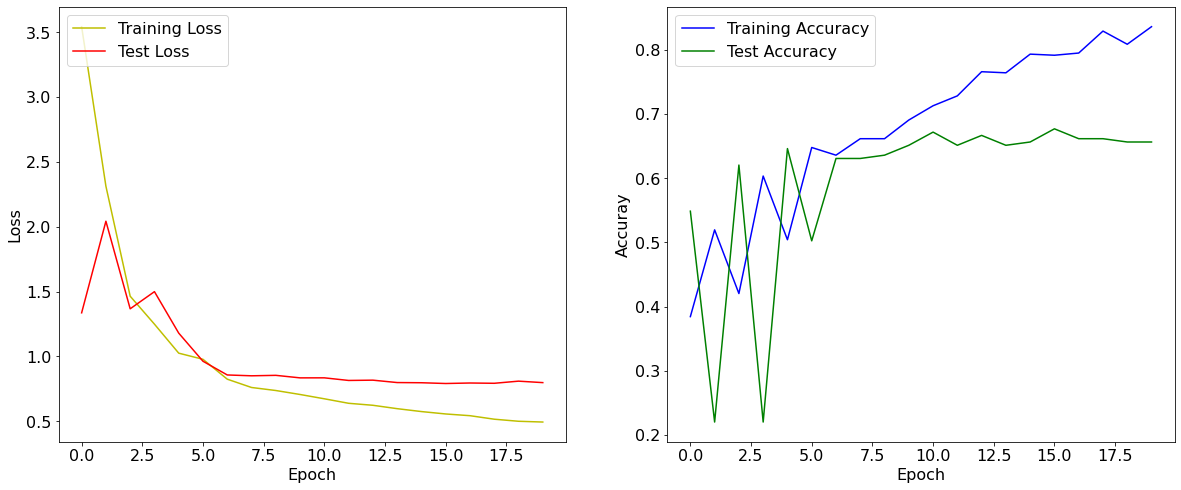

In [11]:
np.random.seed(1)
set_seed(1)

# Define a sequential model and add layers
model1 = Sequential(name='TUMOR_model1')

model1.add(Conv2D(filters=4, kernel_size=3, strides=2, padding='valid', activation='relu', 
                  input_shape=(500, 500, 1)))
model1.add(MaxPooling2D(pool_size=2))

model1.add(Flatten())
model1.add(Dense(units=3, activation='softmax'))

# Print a summary of the model
model1.summary()

# Compile the model, specifying loss, optimizer, and metrics to keep up with while training
opt = optimizers.Adam()
model1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Train the model
hist = model1.fit(x_train, y_train,
                 epochs=20,
                 batch_size=128,
                 validation_data=(x_test, y_test),
                 verbose=0)

# Compute and print final test loss and accuracy
loss_and_acc = model1.evaluate(x_test, y_test, batch_size=np.shape(x_test)[0])
print('Final Test set Loss:',loss_and_acc[0])
print('Final Test set Accuracy:',100*loss_and_acc[1],'%', sep='')
print('Final Test set Misclassification Rate:',100*(1-loss_and_acc[1]),'%', sep='')

# Plot the loss and accuracy for training and validation sets
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

ax1.plot(hist.history['loss'], 'y', label = 'Training Loss')
ax1.plot(hist.history['val_loss'], 'r', label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc = 'upper left')

ax2.plot(hist.history['accuracy'], 'b', label='Training Accuracy')
ax2.plot(hist.history['val_accuracy'], 'g', label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuray')
ax2.legend(loc='upper left');

The first model has 184,555 trainable parameters and has a test set misclassification rate of 34.3590%. The graph on the right shows a trend upwards for both the training accuracy and the testing accuracy as more epochs are used. However, there is a widening gap between the training loss and the testing loss as more epochs are fit. Lets try adding another convolutional layer and max pooling layer to help reduce this test error. 

#### Second model: 2 convolutional layers and 2 max pooling layers

Model: "TUMOR_model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 249, 249, 4)       40        
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 124, 124, 4)      0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 61, 61, 4)         148       
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 30, 30, 4)        0         
 g2D)                                                            
                                                                 
 flatten_18 (Flatten)        (None, 3600)              0         
                                                                 
 dense_23 (Dense)            (None, 3)                

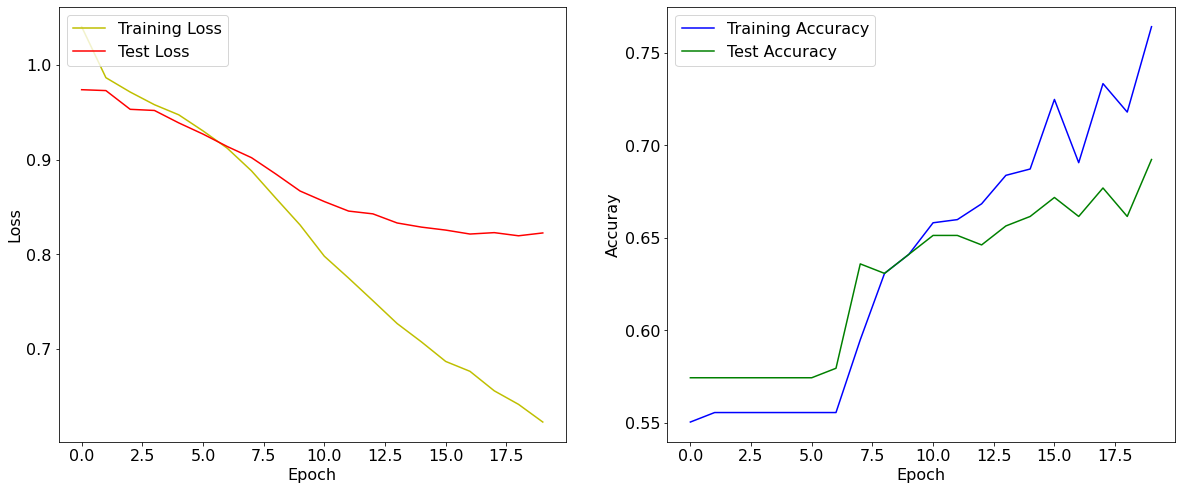

In [78]:
# Define a sequential model and add layers
model2 = Sequential(name='TUMOR_model2')

model2.add(Conv2D(filters=4, kernel_size=3, strides=2, padding='valid', activation='relu', 
                  input_shape=(500, 500, 1)))
model2.add(MaxPooling2D(pool_size=2))

model2.add(Conv2D(filters=4, kernel_size=3, strides=2, padding='valid', activation='relu'))
model2.add(MaxPooling2D(pool_size=2))

model2.add(Flatten())
model2.add(Dense(units=3, activation='softmax'))

# Print a summary of the model
model2.summary()

# Compile the model, specifying loss, optimizer, and metrics to keep up with while training
opt = optimizers.Adam()
model2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Train the model
hist = model2.fit(x_train, y_train,
                 epochs=20,
                 batch_size=128,
                 validation_data=(x_test, y_test),
                 verbose=0)

# Compute and print final test loss and accuracy
loss_and_acc = model2.evaluate(x_test, y_test, batch_size=np.shape(x_test)[0])
print('Final Test set Loss:',loss_and_acc[0])
print('Final Test set Accuracy:',100*loss_and_acc[1],'%', sep='')
print('Final Test set Misclassification Rate:',100*(1-loss_and_acc[1]),'%', sep='')

# Plot the loss and accuracy for training and validation sets
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

ax1.plot(hist.history['loss'], 'y', label = 'Training Loss')
ax1.plot(hist.history['val_loss'], 'r', label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc = 'upper left')

ax2.plot(hist.history['accuracy'], 'b', label='Training Accuracy')
ax2.plot(hist.history['val_accuracy'], 'g', label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuray')
ax2.legend(loc='upper left');

The model with 2 convolutional blocks did indeed lower the test set misclassification rate to 30.7692%. This model also decreased the number of trainable parameters down to 10,991. Perhaps adding another convolutional block will decrease this test error even further. 

#### Third model: 3 convolutional layers and 3 max pooling layers

Model: "TUMOR_model3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 249, 249, 4)       40        
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 124, 124, 4)      0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 61, 61, 4)         148       
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 30, 30, 4)        0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 14, 14, 4)         148       
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 7, 7, 4)         

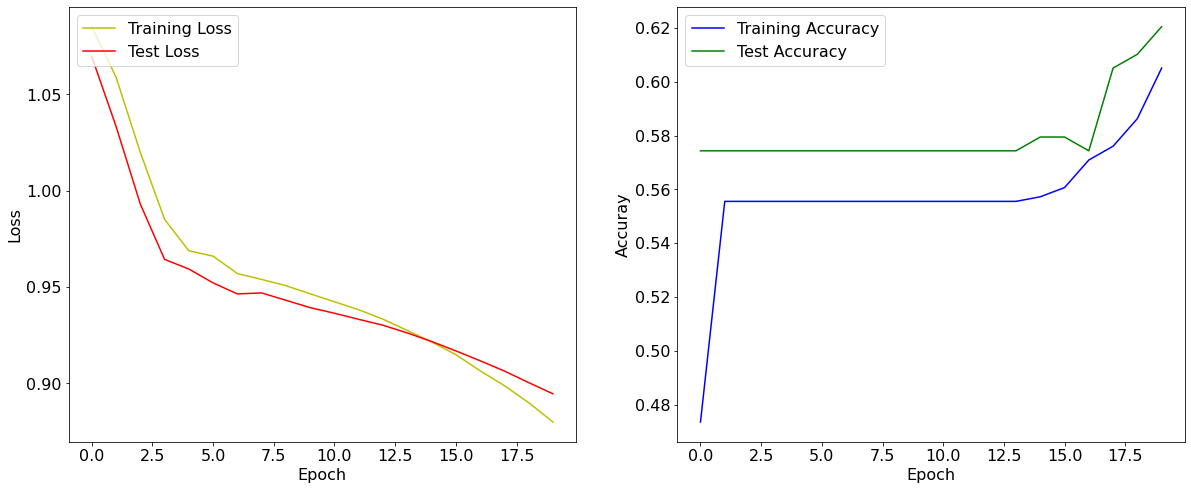

In [79]:
# Define a sequential model and add layers
model3 = Sequential(name='TUMOR_model3')

model3.add(Conv2D(filters=4, kernel_size=3, strides=2, padding='valid', activation='relu', 
                  input_shape=(500, 500, 1)))
model3.add(MaxPooling2D(pool_size=2))

model3.add(Conv2D(filters=4, kernel_size=3, strides=2, padding='valid', activation='relu'))
model3.add(MaxPooling2D(pool_size=2))

model3.add(Conv2D(filters=4, kernel_size=3, strides=2, padding='valid', activation='relu'))
model3.add(MaxPooling2D(pool_size=2))

model3.add(Flatten())
model3.add(Dense(units=3, activation='softmax'))

# Print a summary of the model
model3.summary()

# Compile the model, specifying loss, optimizer, and metrics to keep up with while training
opt = optimizers.Adam()
model3.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Train the model
hist = model3.fit(x_train, y_train,
                 epochs=20,
                 batch_size=128,
                 validation_data=(x_test, y_test),
                 verbose=0)

# Compute and print final test loss and accuracy
loss_and_acc = model3.evaluate(x_test, y_test, batch_size=np.shape(x_test)[0])
print('Final Test set Loss:',loss_and_acc[0])
print('Final Test set Accuracy:',100*loss_and_acc[1],'%', sep='')
print('Final Test set Misclassification Rate:',100*(1-loss_and_acc[1]),'%', sep='')

# Plot the loss and accuracy for training and validation sets
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

ax1.plot(hist.history['loss'], 'y', label = 'Training Loss')
ax1.plot(hist.history['val_loss'], 'r', label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc = 'upper left')

ax2.plot(hist.history['accuracy'], 'b', label='Training Accuracy')
ax2.plot(hist.history['val_accuracy'], 'g', label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuray')
ax2.legend(loc='upper left');


The model with 3 convolutional blocks increased the test set error to 37.9487% which is worse than the model with 1 or 2 convolutional blocks. This implies that the model with only two convolutional blocks fits this data set best. While additional convolutional blocks (beyond 2) did not improve the test set accuracy, there are other layers that we can try. 

#### Add a dense layer with regularization term
Let's see if adding a linear (dense) layer to our 2 convolutional blocks will increase our test set accuracy. The output from the second max pooling layer must be flattened into 1 dimension in order to fit a linear coefficient to each term. We will include a regularization term to avoid overfitting the training data. 

Model: "TUMOR_model4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 249, 249, 4)       40        
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 124, 124, 4)      0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 61, 61, 4)         148       
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 30, 30, 4)        0         
 g2D)                                                            
                                                                 
 flatten_20 (Flatten)        (None, 3600)              0         
                                                                 
 dense_25 (Dense)            (None, 120)              

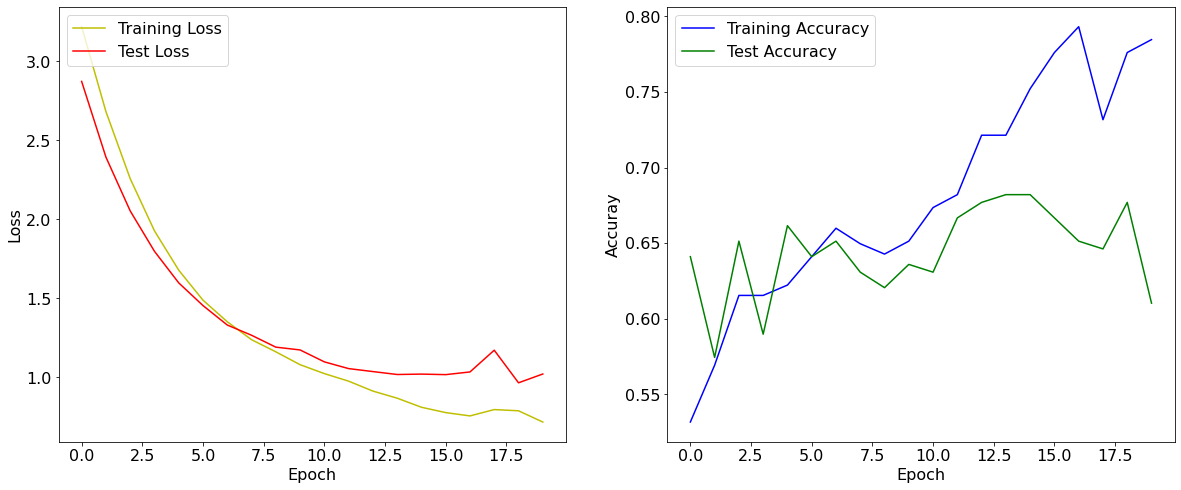

In [80]:
# Define a sequential model and add layers
model4 = Sequential(name='TUMOR_model4')

model4.add(Conv2D(filters=4, kernel_size=3, strides=2, padding='valid', activation='relu', 
                  input_shape=(500, 500, 1)))
model4.add(MaxPooling2D(pool_size=2))

model4.add(Conv2D(filters=4, kernel_size=3, strides=2, padding='valid', activation='relu'))
model4.add(MaxPooling2D(pool_size=2))

model4.add(Flatten())
model4.add(Dense(units=120, kernel_regularizer=l2(.01)))
model4.add(Dense(units=3, activation='softmax'))

# Print a summary of the model
model4.summary()

# Compile the model, specifying loss, optimizer, and metrics to keep up with while training
opt = optimizers.Adam()
model4.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Train the model
hist = model4.fit(x_train, y_train,
                 epochs=20,
                 batch_size=128,
                 validation_data=(x_test, y_test),
                 verbose=0)

# Compute and print final test loss and accuracy
loss_and_acc = model4.evaluate(x_test, y_test, batch_size=np.shape(x_test)[0])
print('Final Test set Loss:',loss_and_acc[0])
print('Final Test set Accuracy:',100*loss_and_acc[1],'%', sep='')
print('Final Test set Misclassification Rate:',100*(1-loss_and_acc[1]),'%', sep='')

# Plot the loss and accuracy for training and validation sets
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

ax1.plot(hist.history['loss'], 'y', label = 'Training Loss')
ax1.plot(hist.history['val_loss'], 'r', label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc = 'upper left')

ax2.plot(hist.history['accuracy'], 'b', label='Training Accuracy')
ax2.plot(hist.history['val_accuracy'], 'g', label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuray')
ax2.legend(loc='upper left');


Adding the linear layer to the 2 convolutional block model increased the test set misclassification rate to 38.9744%. This model also has the highest number of trainable parameters, for it requires 432,671. The dense layer may be overfitting the data despite the regularization term, as shown by the increasing accuracy line for the training set and decreasing accuracy line for the test set. 

#### Add a batch normalization
Batch normalization is another technique commonly used in building artifical neural networks that may speed up model building and reduce overfitting. This process re-centers and re-scales each batch of data with its own mean and standard deviation. Lets see if batch normalization will increase our model's performance on classification of ultrasounds. 

Model: "TUMOR_model5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 249, 249, 4)       40        
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 124, 124, 4)      0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 61, 61, 4)         148       
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 30, 30, 4)        0         
 g2D)                                                            
                                                                 
 batch_normalization_2 (Batc  (None, 30, 30, 4)        16        
 hNormalization)                                                 
                                                      

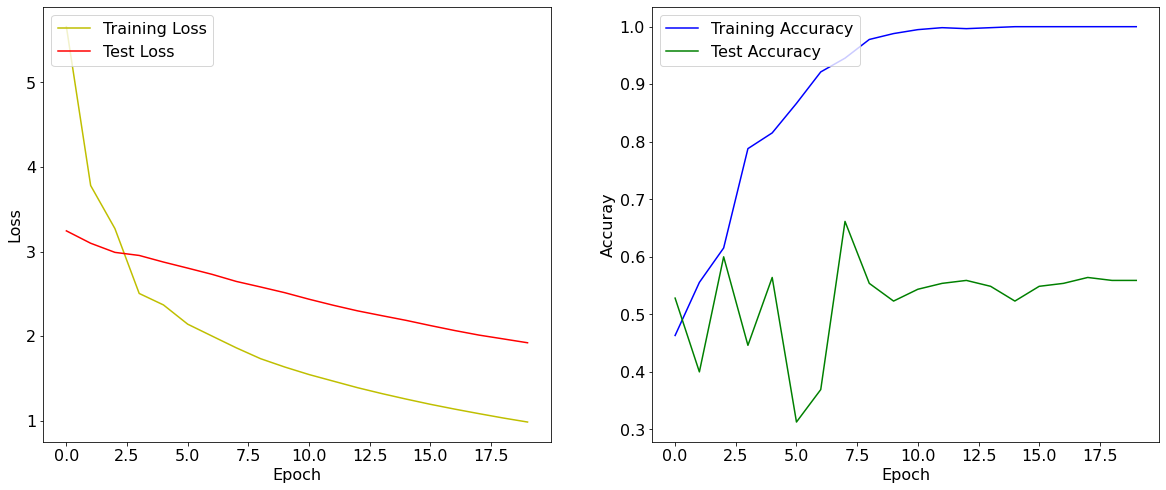

In [81]:
# Define a sequential model and add layers
model5 = Sequential(name='TUMOR_model5')

model5.add(Conv2D(filters=4, kernel_size=3, strides=2, padding='valid', activation='relu', 
                  input_shape=(500, 500, 1)))
model5.add(MaxPooling2D(pool_size=2))

model5.add(Conv2D(filters=4, kernel_size=3, strides=2, padding='valid', activation='relu'))
model5.add(MaxPooling2D(pool_size=2))

model5.add(BatchNormalization())

model5.add(Flatten())
model5.add(Dense(units=120, kernel_regularizer=l2(.01)))
model5.add(Dense(units=3, activation='softmax'))

# Print a summary of the model
model5.summary()

# Compile the model, specifying loss, optimizer, and metrics to keep up with while training
opt = optimizers.Adam()
model5.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Train the model
hist = model5.fit(x_train, y_train,
                 epochs=20,
                 batch_size=128,
                 validation_data=(x_test, y_test),
                 verbose=0)

# Compute and print final test loss and accuracy
loss_and_acc = model5.evaluate(x_test, y_test, batch_size=np.shape(x_test)[0])
print('Final Test set Loss:',loss_and_acc[0])
print('Final Test set Accuracy:',100*loss_and_acc[1],'%', sep='')
print('Final Test set Misclassification Rate:',100*(1-loss_and_acc[1]),'%', sep='')


# Plot the loss and accuracy for training and validation sets
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

ax1.plot(hist.history['loss'], 'y', label = 'Training Loss')
ax1.plot(hist.history['val_loss'], 'r', label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc = 'upper left')

ax2.plot(hist.history['accuracy'], 'b', label='Training Accuracy')
ax2.plot(hist.history['val_accuracy'], 'g', label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuray')
ax2.legend(loc='upper left');


The Batch Normalization layer increased the misclassification rate even higher to 44.1026%. Let's remove the batch normalization and try adding a dropout layer instead. 

#### Add a dropout layer
Dropout layers randomly drop a fraction of each layers' inputs when building the model. This random drop of inputs reduces overfitting of random noise in the training set. We will drop out 25% of inputs.

Model: "TUMOR_model6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 249, 249, 4)       40        
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 124, 124, 4)      0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 61, 61, 4)         148       
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 30, 30, 4)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 30, 30, 4)         0         
                                                                 
 flatten_22 (Flatten)        (None, 3600)             

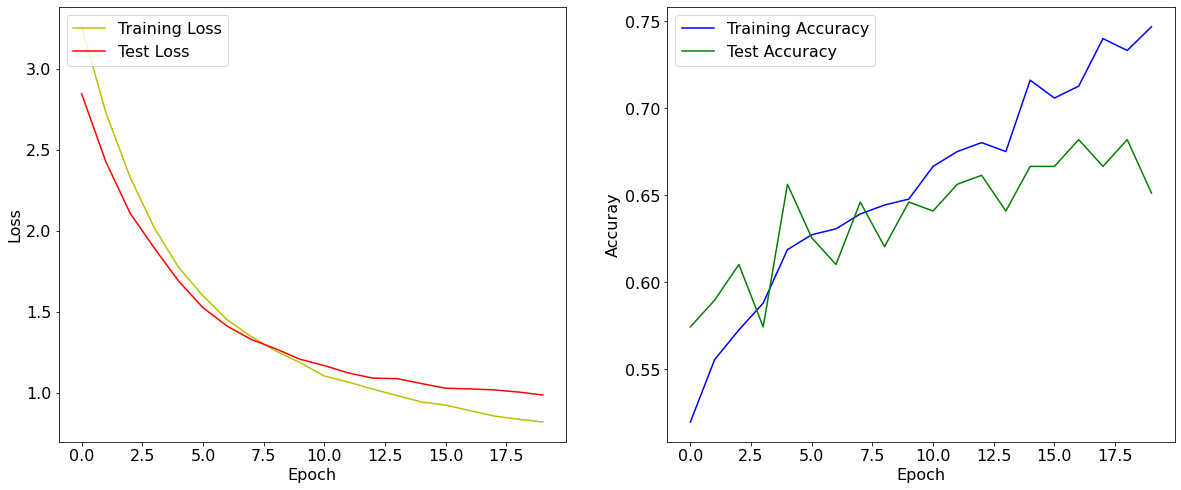

In [82]:
# Define a sequential model and add layers
model6 = Sequential(name='TUMOR_model6')

model6.add(Conv2D(filters=4, kernel_size=3, strides=2, padding='valid', activation='relu', 
                  input_shape=(500, 500, 1)))
model6.add(MaxPooling2D(pool_size=2))

model6.add(Conv2D(filters=4, kernel_size=3, strides=2, padding='valid', activation='relu'))
model6.add(MaxPooling2D(pool_size=2))

model6.add(Dropout(0.25))

model6.add(Flatten())
model6.add(Dense(units=120, kernel_regularizer=l2(.01)))

model6.add(Dropout(0.25))
model6.add(Dense(units=3, activation='softmax'))

# Print a summary of the model
model6.summary()

# Compile the model, specifying loss, optimizer, and metrics to keep up with while training
opt = optimizers.Adam()
model6.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Train the model
hist = model6.fit(x_train, y_train,
                 epochs=20,
                 batch_size=128,
                 validation_data=(x_test, y_test),
                 verbose=0)

# Compute and print final test loss and accuracy
loss_and_acc = model6.evaluate(x_test, y_test, batch_size=np.shape(x_test)[0])
print('Final Test set Loss:',loss_and_acc[0])
print('Final Test set Accuracy:',100*loss_and_acc[1],'%', sep='')
print('Final Test set Misclassification Rate:',100*(1-loss_and_acc[1]),'%', sep='')

# Plot the loss and accuracy for training and validation sets
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

ax1.plot(hist.history['loss'], 'y', label = 'Training Loss')
ax1.plot(hist.history['val_loss'], 'r', label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc = 'upper left')

ax2.plot(hist.history['accuracy'], 'b', label='Training Accuracy')
ax2.plot(hist.history['val_accuracy'], 'g', label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuray')
ax2.legend(loc='upper left');

The dropout layer did help lower the misclassification rate with the added dense layer from 38.9744% to 34.8718%. However, the model with the lowest error rate is still the 2 block layer without the dense layer (30.7692%), so we will use this second model going forward. 

### Data Augumentation
Data Augumentation is a deep learning technique that artificially expands the size of the dataset by creating modified versions of the original training images with the intuition that a larger number of images to train our model on will increase its accuracy (Brownlee). We will use a horizontal flip, a vertical flip, a horizontal shift, a vertical shift, a random rotation, and a random zoom on our training images. A visualization of each technique is shown using a training image of a benign tumor.

#### Horizontal Flip

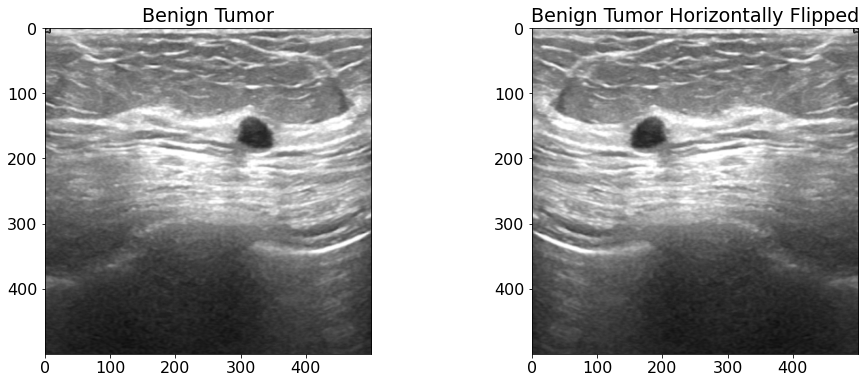

In [96]:
sample = np.expand_dims(x_train[1], 0)

# data generator for horizontal flip of images
datagen1 = ImageDataGenerator(horizontal_flip=True)
it1 = datagen1.flow(sample, batch_size=1)
batch = it1.next()

# plot one image before and after we horizontally flip it
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
ax1.imshow(x_train[1], cmap = "gray")
ax2.imshow(batch[0].astype('float32'), cmap = "gray")
ax1.title.set_text("Benign Tumor")
ax2.title.set_text("Benign Tumor Horizontally Flipped")
plt.show();

#### Vertical Flip

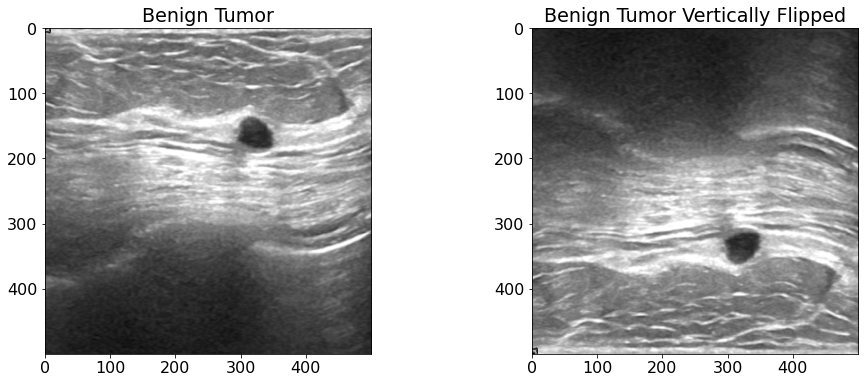

In [97]:
# data generator for vertical flip of images
datagen2 = ImageDataGenerator(vertical_flip=True)
it2 = datagen2.flow(sample, batch_size=1)
batch = it2.next()

# plot one image before and after we vertically flip it
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
ax1.imshow(x_train[1], cmap = "gray")
ax2.imshow(batch[0].astype('float32'), cmap = "gray")
ax1.title.set_text("Benign Tumor")
ax2.title.set_text("Benign Tumor Vertically Flipped")
plt.show();

#### Horizontal Shift

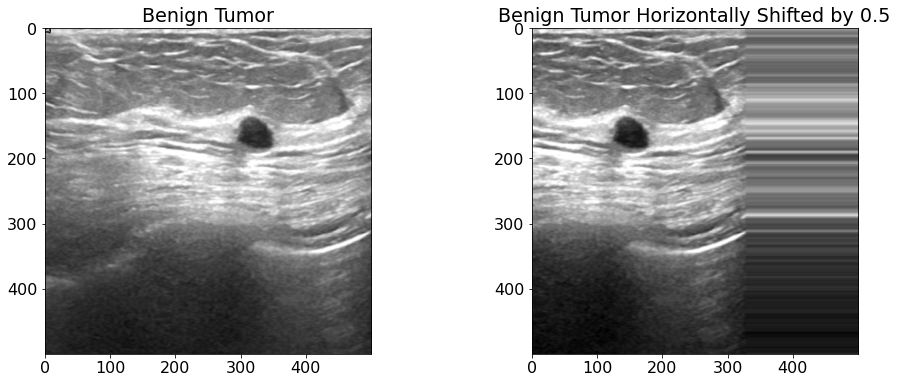

In [101]:
# data generator for width shift of images
datagen3 = ImageDataGenerator(width_shift_range=0.5)
it3 = datagen3.flow(sample, batch_size=1)
batch = it3.next()

# plot one image before and after we horizontally shift it
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
ax1.imshow(x_train[1], cmap = "gray")
ax2.imshow(batch[0].astype('float32'), cmap = "gray")
ax1.title.set_text("Benign Tumor")
ax2.title.set_text("Benign Tumor Horizontally Shifted by 0.5")
plt.show();

#### Vertical Shift

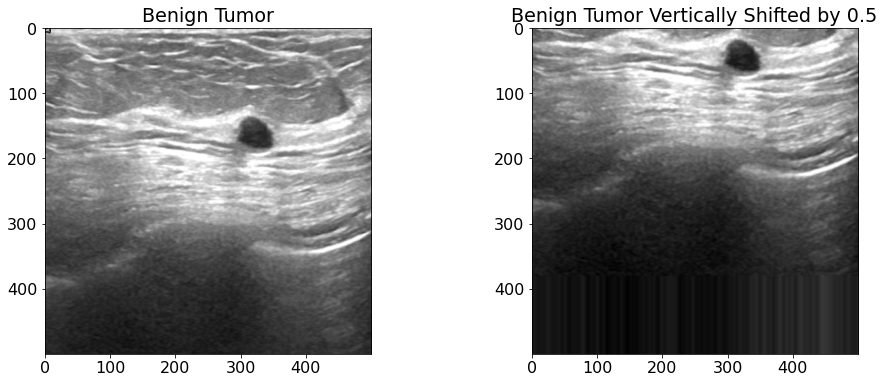

In [102]:
# data generator for height shift of images
datagen4 = ImageDataGenerator(height_shift_range=0.5)
it4 = datagen4.flow(sample, batch_size=1)
batch = it4.next()

# plot one image before and after we vertically shift it
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
ax1.imshow(x_train[1], cmap = "gray")
ax2.imshow(batch[0].astype('float32'), cmap = "gray")
ax1.title.set_text("Benign Tumor")
ax2.title.set_text("Benign Tumor Vertically Shifted by 0.5")
plt.show();

#### Random Rotation

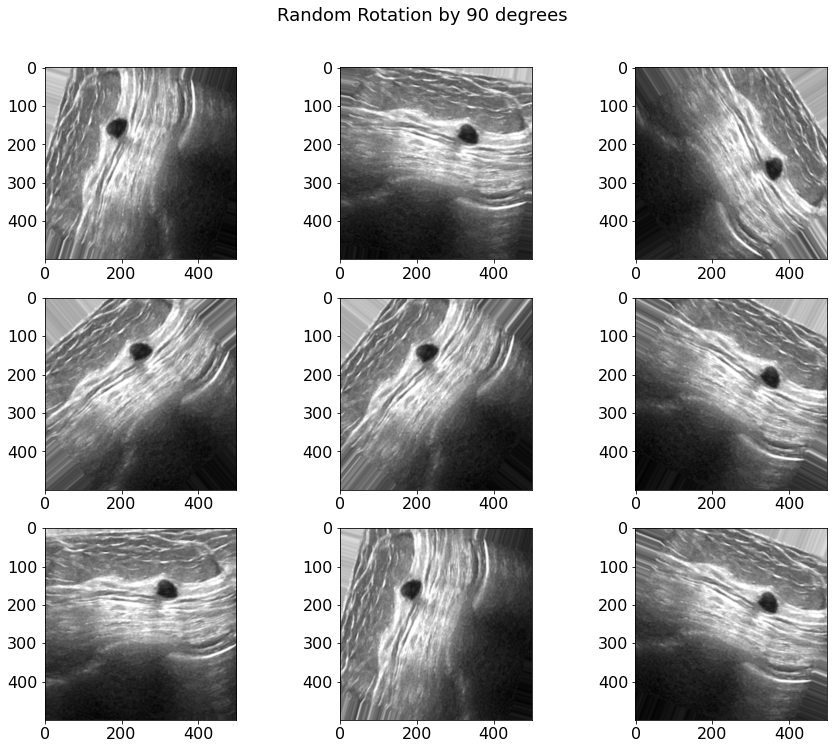

In [106]:
# data generator for random rotation of images
datagen5 = ImageDataGenerator(rotation_range=90)
it5 = datagen5.flow(sample, batch_size=1)

plt.figure(figsize=(15, 12))
plt.suptitle("Random Rotation by 90 degrees", fontsize=18, y=0.95)

# plot one image randomly rotated 90 degrees
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    batch = it5.next()
    ax.imshow(batch[0].astype('float32'), cmap = "gray")

plt.show()

### Random Zoom

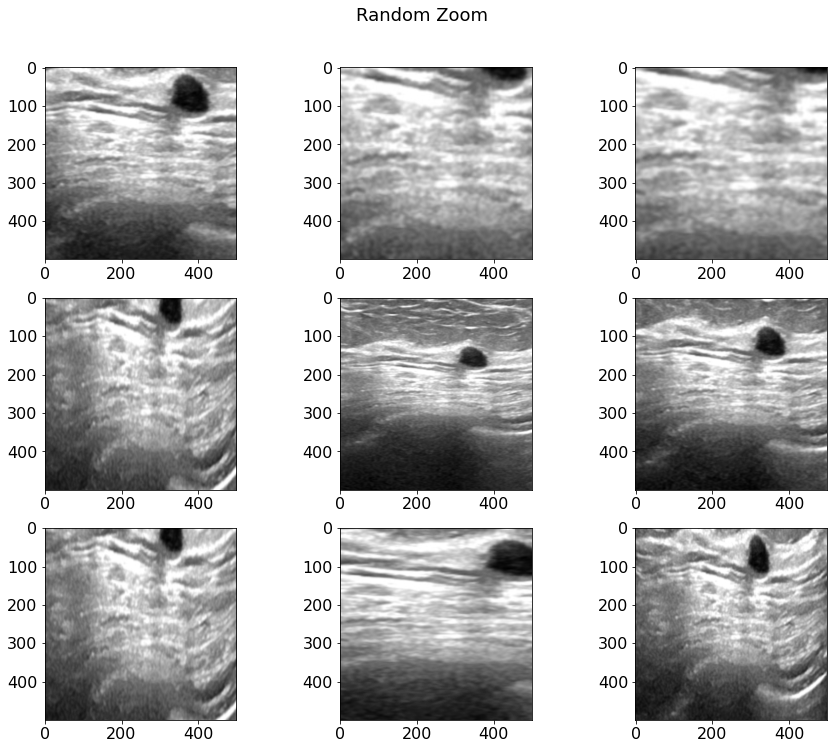

In [109]:
# data generator for random zoom of images
datagen6 = ImageDataGenerator(zoom_range=[0.25,1.0])
it6 = datagen6.flow(sample, batch_size=1)
batch = it6.next()

plt.figure(figsize=(15, 12))
plt.suptitle("Random Zoom", fontsize=18, y=0.95)

# plot one image randomly rotated 90 degrees
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    batch = it6.next()
    ax.imshow(batch[0].astype('float32'), cmap = "gray")

plt.show()

### Model using augmented training images
The artificially augmented training images will be fed into our 2 block model using a data generator. We will double the batch size to 256 and increase the number of epochs to 40 to account for the newly generated images. 

In [83]:
# data generator
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, 
                             width_shift_range=0.5, height_shift_range=0.5, 
                             rotation_range=90, zoom_range=[0.5,1.0])

it = datagen.flow(x_train, y_train, batch_size=256)

# Train the model
hist = model2.fit(it, 
                 epochs=40,
                 validation_data=(x_test, y_test),
                 verbose=0)

# Plot the loss and accuracy for training and validation sets
ax1.plot(hist.history['loss'], 'y', label = 'Training Loss')
ax1.plot(hist.history['val_loss'], 'r', label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc = 'upper left')

ax2.plot(hist.history['accuracy'], 'b', label='Training Accuracy')
ax2.plot(hist.history['val_accuracy'], 'g', label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuray')
ax2.legend(loc='upper left');

# Compute and print final test loss and accuracy
loss_and_acc = model2.evaluate(x_test, y_test, batch_size=np.shape(x_test)[0])
print('Final Test set Loss:',loss_and_acc[0])
print('Final Test set Accuracy:',100*loss_and_acc[1],'%', sep='')
print('Final Test set Misclassification Rate:',100*(1-loss_and_acc[1]),'%', sep='')

1/1 [==============================] - 1s 914ms/step - loss: 0.9393 - accuracy: 0.5744
Final Test set Loss: 0.9393244981765747
Final Test set Accuracy:57.43589997291565%
Final Test set Misclassification Rate:42.56410002708435%


Unfortunately data augumentation did not improve our model performance, for the test set misclassification rate is 42.5641%. This may be due to the nature of ultrasound images, for they may not have features that generalize well when augmented. 

### Pre-trained network: image classification using VGG16
The final technique we can try is Transfer Learning. Transfer Learning applies a state-of-the art deep neural network that has been trained on other images to classify our own. These models learn parameters using a specific dataset and produce highly accurate results. VGG16 is a convolutional network trained on ImageNet, a dataset of 14 million images belonging to 1000 classes. This model has an accuracy rate of 92.7% on ImageNet (Hassan). We can use VGG16 on our ultrasound images, but need to process the input and output to match our image size and number of classes. ImageNet consists of colored images, meaning each one has 3 channels. Since VGG16 was trained on ImageNet, it expects images with 3 channels. Our ultrasounds are black and white, and only have 1 channel. We can work around this discrepancy by simply duplicating the black and white channel across 3 channels for each image. 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500, 500, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 500, 500, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 500, 500, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 250, 250, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 250, 250, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 250, 250, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 125, 125, 128)     0     

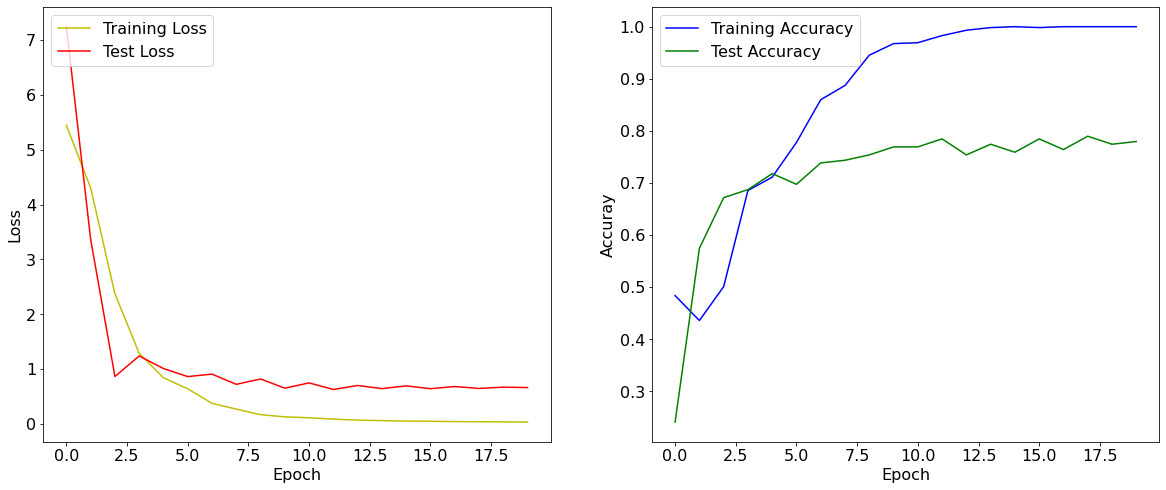

In [12]:
# Re-shape grayscale images into rgb images by repeating image array across 3 channels
xtrainsq = np.squeeze(x_train)
rgb_xtrain = np.repeat(xtrainsq[..., np.newaxis], 3, -1)

xtestq = np.squeeze(x_test)
rgb_xtest = np.repeat(xtestq[..., np.newaxis], 3, -1)
    
# Load the pre-trained VGG16 model
PreTrainedModel = tensorflow.keras.applications.VGG16(include_top=False, 
                                                      input_tensor=Input(shape=(500, 500, 3)), 
                                                      classes=3)

# Freeze weights in pre-trained layers
for layer in PreTrainedModel.layers:
      layer.trainable = False

# take the output from the last layer and flatten it
flat1 = Flatten()(PreTrainedModel.layers[-1].output)
output = Dense(3, activation='softmax')(flat1)

MyModel = Model(inputs=PreTrainedModel.inputs, outputs=output)

# Print a summary of the model
MyModel.summary()

# Compile the model
opt = optimizers.Adam()
MyModel.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Train the model
hist = MyModel.fit(rgb_xtrain, y_train,
                 epochs=20,
                 batch_size=128,
                 validation_data=(rgb_xtest, y_test),
                 verbose=1)

# Compute and print final test loss and accuracy
loss_and_acc = MyModel.evaluate(rgb_xtest, y_test, batch_size=np.shape(rgb_xtest)[0])
print('Final Test set Loss:',loss_and_acc[0])
print('Final Test set Accuracy:',100*loss_and_acc[1],'%')
print('Final Test set Misclassification Rate:',100*(1-loss_and_acc[1]),'%')

# Plot the loss and accuracy for training and validation sets
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

ax1.plot(hist.history['loss'], 'y', label = 'Training Loss')
ax1.plot(hist.history['val_loss'], 'r', label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc = 'upper left')

ax2.plot(hist.history['accuracy'], 'b', label='Training Accuracy')
ax2.plot(hist.history['val_accuracy'], 'g', label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuray')
ax2.legend(loc='upper left');


VGG16 has a test set misclassification rate of 22.0513% on our ultrasounds. This model has 14,714,688 pre-trained parameters and needs to train an additional 345,603 parameters in order to use the softmax activation function. Due to the size of the model, it takes significantly more time and memory to run compared to previous models evaluated.

### Conclusion
There are a variety of different layering techniques to build a deep neural network for classification of ultrasounds. The best model built by hand had two convolutional layers followed by two max pooling layers. Adding a linear layer did not improve our test set accuracy despite including a regularization term and trying batch normalization and dropout. The two-block model had a test set misclassification rate of 30.7692% and a corresponding accuracy rate of 69.2307%. We suspected the small size of the dataset was limiting the accuracy of the model and experimented with data augmentation. However, generating more training images did not improve the model fit, for the test set misclassification rate was 42.5641% using data augmentation. Lastly, we tried using transfer learning through VGG16 to classify the ultrasounds. The VGG16 model had a test set misclassification rate of 22.0513%, but was computationally more expensive than the other models. In the end, the best deep neural network for this data set was VGG16.

### References
Al-Dhabyani W, Gomaa M, Khaled H, Fahmy A. Dataset of breast ultrasound images. Data in Brief. 2020 Feb;28:104863. DOI: 10.1016/j.dib.2019.104863

Brownlee, Jason. “How to Configure Image Data Augmentation in Keras.” Machine Learning Mastery, 5 July 2019, https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/. Accessed 4 Jan. 2022. 

Conway Medical Center. “Is an Ultrasound Better than a Mammogram?” Conway Medical Center, 23 Oct. 2020, https://www.conwaymedicalcenter.com/news/ultrasound-vs-mammogram-faqs. 

Hassan, Muneeb ul. “VGG16 – Convolutional Network for Classification and Detection.” Neurohive, 20 Nov. 2018, https://neurohive.io/en/popular-networks/vgg16/. Accessed 4 Jan. 2022. 